<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dogs-vs-Cats" data-toc-modified-id="Dogs-vs-Cats-1">Dogs vs Cats</a></span><ul class="toc-item"><li><span><a href="#Функции-загрузки-данных" data-toc-modified-id="Функции-загрузки-данных-1.1">Функции загрузки данных</a></span></li><li><span><a href="#Визуализируем-примеры-для-обучения" data-toc-modified-id="Визуализируем-примеры-для-обучения-1.2">Визуализируем примеры для обучения</a></span></li><li><span><a href="#Загружаем-предобученную-модель" data-toc-modified-id="Загружаем-предобученную-модель-1.3">Загружаем предобученную модель</a></span></li><li><span><a href="#Добавляем-полносвязный-слой" data-toc-modified-id="Добавляем-полносвязный-слой-1.4">Добавляем полносвязный слой</a></span></li><li><span><a href="#Выводим-архитектуру-модели" data-toc-modified-id="Выводим-архитектуру-модели-1.5">Выводим архитектуру модели</a></span></li><li><span><a href="#Компилируем-модель-и-запускаем-обучение" data-toc-modified-id="Компилируем-модель-и-запускаем-обучение-1.6">Компилируем модель и запускаем обучение</a></span></li><li><span><a href="#Предсказания-на-проверочной-выборке" data-toc-modified-id="Предсказания-на-проверочной-выборке-1.7">Предсказания на проверочной выборке</a></span></li><li><span><a href="#Готовим-данные-для-отправки" data-toc-modified-id="Готовим-данные-для-отправки-1.8">Готовим данные для отправки</a></span></li></ul></li></ul></div>

# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.7.0
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('006_data/train/*.jpg')
test_files = glob('006_data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=40):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [3]:
len(train_files),len(test_files)

(25000, 12500)

## Визуализируем примеры для обучения

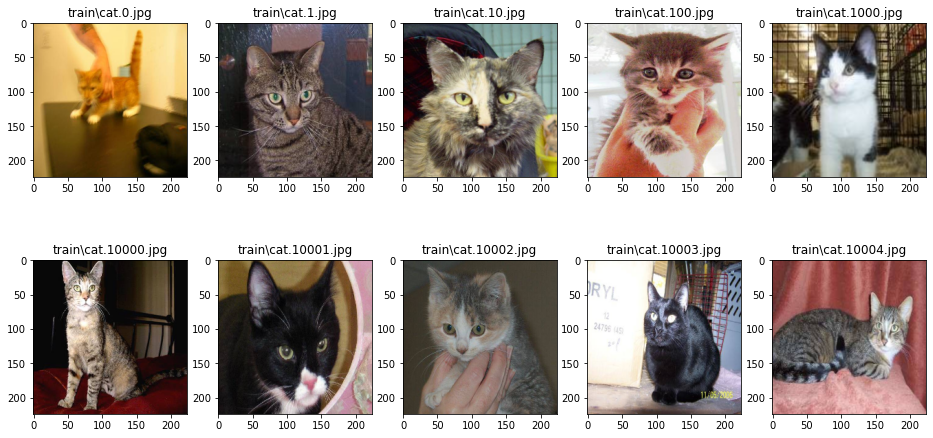

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [5]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [7]:
# фиксируем все веса предобученной сети
# for layer in base_model.layers:
#     layer.trainable = False
base_model.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [8]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [9]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [10]:
val_samples = int(0.3*len(train_files))  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], batch_size=40))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=50,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/50
10/10 [==============================] - 57s 6s/step - loss: 0.7626 - accuracy: 0.6300 - val_loss: 0.6378 - val_accuracy: 0.6750
Epoch 2/50
10/10 [==============================] - 59s 6s/step - loss: 0.6439 - accuracy: 0.6700 - val_loss: 0.5553 - val_accuracy: 0.7000
Epoch 3/50
10/10 [==============================] - 61s 6s/step - loss: 0.6323 - accuracy: 0.6675 - val_loss: 0.8841 - val_accuracy: 0.5250
Epoch 4/50
10/10 [==============================] - 59s 6s/step - loss: 0.6295 - accuracy: 0.6600 - val_loss: 0.8734 - val_accuracy: 0.5500
Epoch 5/50
10/10 [==============================] - 60s 6s/step - loss: 0.5737 - accuracy: 0.7050 - val_loss: 0.7038 - val_accuracy: 0.5500
Epoch 6/50
10/10 [==============================] - 62s 6s/step - loss: 0.4920 - accuracy: 0.7600 - val_loss: 0.5429 - val_accuracy: 0.6500
Epoch 7/50
10/10 [==============================] - 58s 6s/step - loss: 0.4813 - accuracy: 0.7625 - val_loss: 0.4010 - val_accuracy: 0.7750
Epoch 8/50
10/10 [==

In [11]:
model.save('cats-dogs-vgg16-2.hdf5')

## Предсказания на проверочной выборке

In [12]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

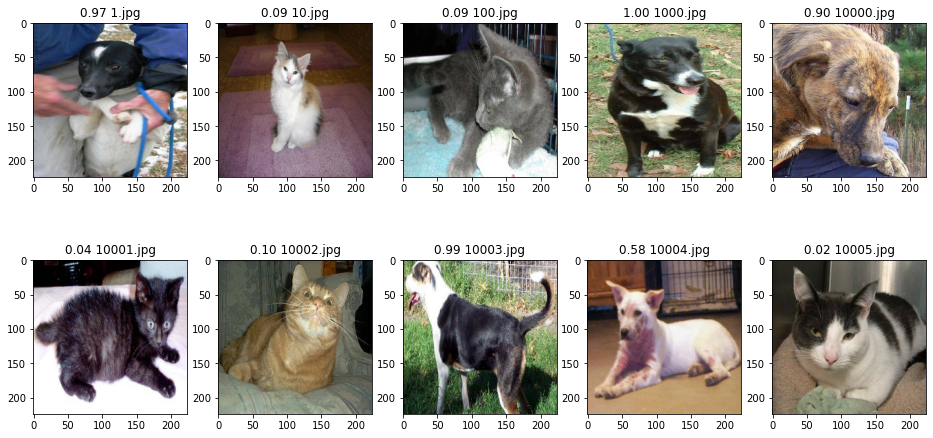

In [13]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [14]:
import re

with open('submit_Dogs_vs_Cats_2.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))